In [71]:
import numpy as np
import sys
import os
sys.path.append("/home1/efeghhi/ripple_memory")
from load_data import * 
from analyze_data import * 
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                        MFG_labels, IFG_labels, nonHPC_MTL_labels, ENTPHC_labels, AMY_labels
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from helper_funcs import plot_SME_high_low_HFA, make_plot
import copy

In [2]:
############### set parameters ###############
save_data = True
start_time = -700 # recording start time relative to word onset (ms)
end_time = 2300 # recording end time relative to word onset (ms)
HFA_start = 400
HFA_end = 1100
encoding_mode = 1
sr = 50 # Hz
sr_factor = 1000/sr
##############################################

# load data and remove lists of wrong length
if encoding_mode:
    catFR_dir = '/scratch/efeghhi/catFR1/ENCODING/'
    relevant_keys = ['position', 'correct', 'clust', 'subj', 'sess', 'list_num', 'serial_pos']
else:
    catFR_dir = '/scratch/efeghhi/catFR1/IRIonly/'
    relevant_keys = ['subj', 'sess', 'list_num', 'serial_pos']


region_name = '' # if empty string, loads all data

data_dict = load_data(catFR_dir, region_name, encoding_mode=encoding_mode, condition_on_ca1_ripples=False)
if encoding_mode:
    data_dict = remove_wrong_length_lists(data_dict)
    
# divide data by region
# ca1
ca1_elecs = [x for x in HPC_labels if 'ca1' in x]
data_dict_ca1 = select_region(data_dict, ca1_elecs)    
count_num_trials(data_dict_ca1, "ca1")

# amy
ca3_dg_elecs = [x for x in HPC_labels if 'dg' in x]
data_dict_ca3_dg = select_region(data_dict, ca3_dg_elecs)
count_num_trials(data_dict_ca3_dg, "ca3_dg")

data_dict_entphc = select_region(data_dict, ENTPHC_labels)
count_num_trials(data_dict_entphc, "entphc")

data_dict_amy = select_region(data_dict, AMY_labels)
count_num_trials(data_dict_amy, "amy")

Number of trials in ca1: 113628
Number of trials in ca3_dg: 61212
Number of trials in entphc: 47232
Number of trials in amy: 49176


In [3]:
savefigs = '/home1/efeghhi/ripple_memory/figures/misc/'

In [4]:
HFA_start_idx = int((HFA_start - start_time) / sr_factor)
HFA_end_idx = int((HFA_end - start_time) / sr_factor)

order: C
Num high HFA:  22726
Num low HFA:  90902


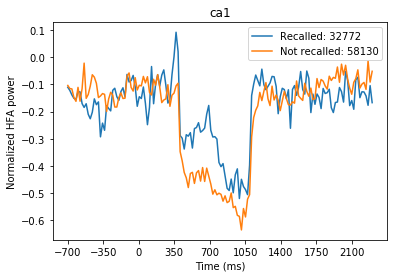

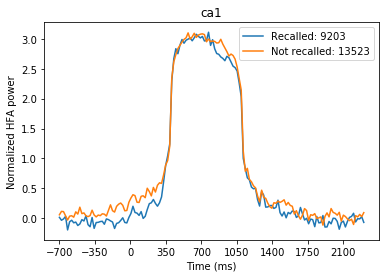

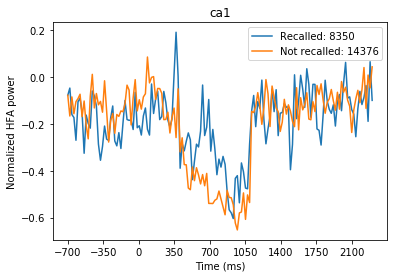

In [31]:
plot_SME_high_low_HFA(data_dict_ca1, 'ca1', HFA_start_idx, HFA_end_idx)

order: C
Num high HFA:  12243
Num low HFA:  48969


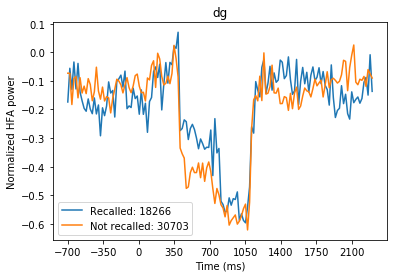

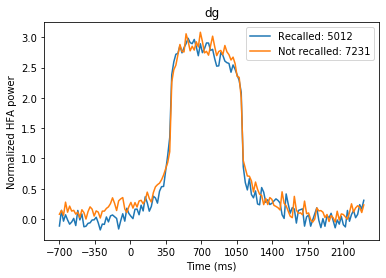

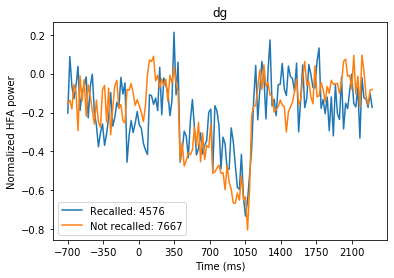

In [32]:
plot_SME_high_low_HFA(data_dict_ca3_dg, 'dg', HFA_start_idx, HFA_end_idx)

order: C
Num high HFA:  9835
Num low HFA:  39340


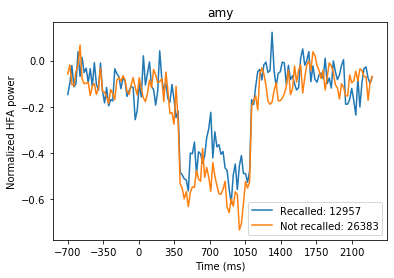

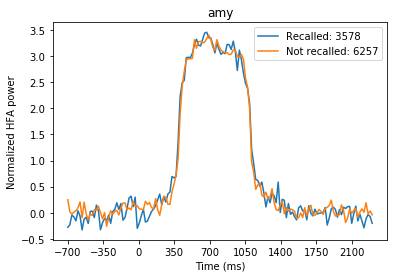

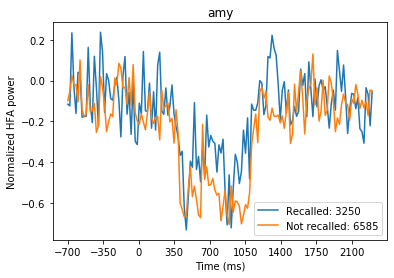

In [33]:
plot_SME_high_low_HFA(data_dict_amy, 'amy', HFA_start_idx, HFA_end_idx)

order: C
Num high HFA:  9447
Num low HFA:  37785


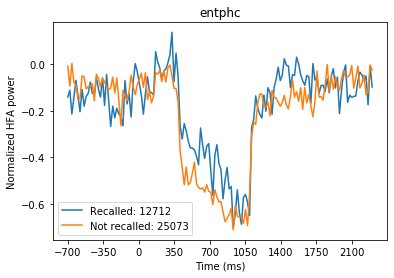

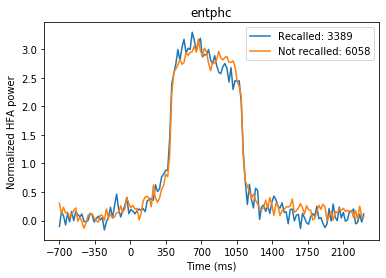

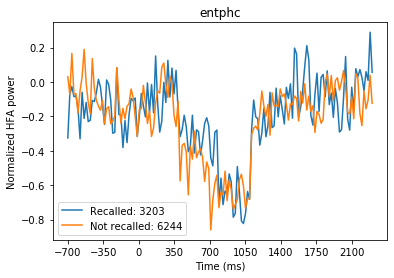

In [34]:
plot_SME_high_low_HFA(data_dict_entphc, 'entphc', HFA_start_idx, HFA_end_idx)

In [95]:
# order F places all data from a given electrode next to each other 
data_dict_ca1_np = dict_to_numpy(data_dict_ca1, order='F') 
HFA = data_dict_ca1_np['HFA']

order: F


In [101]:
sess = data_dict_ca1_np['sess']
elec_names = data_dict_ca1_np['elec_names']
ripple_exists = create_ripple_exists(data_dict_ca1_np)
ripples_by_HFA_levels = {'0.25': [], '0.5': [], '0.75':[], '1':[]}
HFA_ripples_low_quantile = []
candidate_thresh_stored = []
candidate_SD = 3
for sn, s in enumerate(np.unique(data_dict_ca1_np['sess'])):
    s_idxs = np.argwhere(sess==s)
    elec_names_s = elec_names[s_idxs]
    for e in np.unique(elec_names_s):
        e_idxs = np.argwhere(elec_names == e)
        se_idxs = np.intersect1d(s_idxs, e_idxs) 
        HFA_se = HFA[se_idxs].squeeze()

        # compute mean and SD and use for clipping 
        mean_HFA_se_scalar = np.mean(HFA_se)
        SD_HFA_se_scalar = np.std(HFA_se)
        clip_thresh = mean_HFA_se_scalar + candidate_SD*SD_HFA_se_scalar
        HFA_se_clipped = copy.deepcopy(HFA_se)
        HFA_se_clipped[HFA_se_clipped>clip_thresh] = clip_thresh

        # recompute SD and mean after clipping to compute candidate_thresh 
        SD_HFA_clipped = np.std(HFA_se_clipped)
        mean_HFA_clipped = np.mean(HFA_se_clipped)
        candidate_thresh = mean_HFA_clipped + candidate_SD*SD_HFA_clipped
        
        ripple_exists_se = ripple_exists[se_idxs].squeeze()
        mean_HFA = np.mean(HFA_se[:, HFA_start_idx:HFA_end_idx], axis=1)
        mean_HFA_percentile = np.percentile(mean_HFA, [25, 50, 75])
        smallest_HFA_idxs = np.argwhere(mean_HFA< mean_HFA_percentile[0])
        medium_HFA_idxs = np.argwhere((mean_HFA < mean_HFA_percentile[1]) & (mean_HFA > mean_HFA_percentile[0]))
        large_HFA_idxs = np.argwhere((mean_HFA < mean_HFA_percentile[2]) & (mean_HFA > mean_HFA_percentile[1]))
        highest_HFA_idxs = np.argwhere(mean_HFA > mean_HFA_percentile[2])
        HFA_idxs_quantiles = {'0.25': smallest_HFA_idxs, '0.5': medium_HFA_idxs, '0.75': large_HFA_idxs, 
                            '1': highest_HFA_idxs}
        for key, val in HFA_idxs_quantiles.items():
            ripples_by_HFA_levels[key].append(np.sum(ripple_exists_se[val.squeeze()]))
            if key == '0.25':
                ripples_idxs = np.argwhere(ripple_exists_se==1)
                ripples_low_HFA_idxs = np.intersect1d(val, ripples_idxs)
                if len(ripples_low_HFA_idxs)>0:
                    print(ripples_low_HFA_idxs)
                    candidate_thresh_stored.extend(np.repeat(candidate_thresh, ripples_low_HFA_idxs.shape[0]))
                    HFA_ripples_low_quantile.append(HFA_se[ripples_low_HFA_idxs].squeeze())
            break
        break
    break
                    

[ 50  53  65 114 136 140 195 196 217 224 265 296]


In [115]:
HFA_low_ripple = np.vstack(HFA_ripples_low_quantile)
candidate_thresh_np = np.array(candidate_thresh_stored)

In [106]:
for idx, s in enumerate(data_dict_ca1['sess']):
    if 'R1004D-0' in s:
        print(idx)
        print(s.shape)

3
(300, 2)


In [107]:
eeg_rip = np.load('/home1/efeghhi/ripple_memory/eeg_rip_R1004D-0_ca1.npy')
eeg_rip_0 = eeg_rip[:, 0, :]
print(np.mean(eeg_rip_0))

1.8068149616742497


In [108]:
HFA_0 = data_dict_ca1['HFA'][3][:, 0, :]
np.mean(HFA_0[50])

-0.42055152547328345

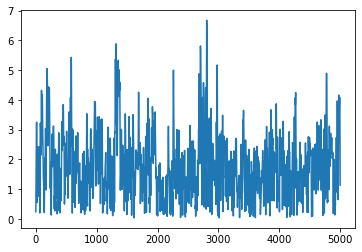

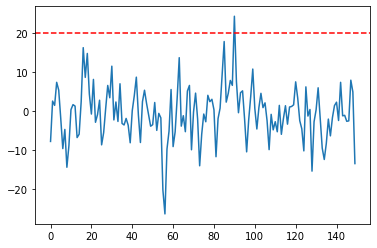

In [120]:
for i in range(HFA_low_ripple.shape[0]):
plt.plot(HFA_low_ripple[0])
plt.axhline(candidate_thresh_stored[0], color='r', linestyle='--')

In [49]:
idx=0
mh = round(np.mean(HFA_low_ripple[idx][HFA_start_idx:HFA_end_idx]),4)
print(mh)
np.mean(HFA_3_0[57][HFA_start_idx:HFA_end_idx])

-2.0217


-2.4898863979199453

In [18]:
data_dict_ca1['elec_names'][0]

array(['left ca1', 'left ca1', 'left ca1', 'left ca1'], dtype='<U8')

In [7]:
HFA_low_ripple = np.vstack(HFA_ripples_low_quantile)
candidate_thresh_stored = np.array(candidate_thresh_stored)

In [8]:
candidate_thresh_stored

array([17.88263499, 17.88263499, 17.88263499, ..., 29.23508558,
       29.23508558, 29.23508558])

array([[1773]])

1.0


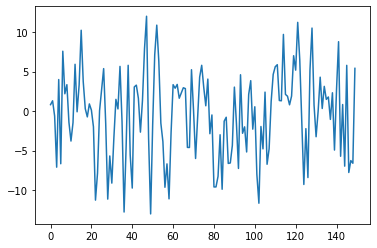

In [10]:
print(ripple_exists[1773])
plt.plot(HFA[1773])
plt.show()

-2.022


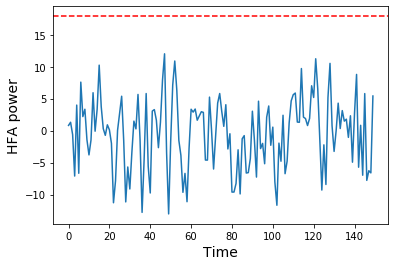

In [11]:
idx = 0
plt.plot(HFA_low_ripple[idx])
print(round(np.mean(HFA_low_ripple[idx][HFA_start_idx:HFA_end_idx]), 3))
plt.axhline(candidate_thresh_stored[0], color='r', linestyle='--')
plt.ylabel("HFA power", fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.savefig(f"{savefigs}/thresh_not_reached.png", dpi=300)
plt.show()

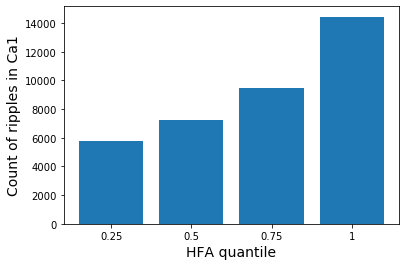

In [41]:
ripple_by_HFA_quantile = {key:0 for key in ripples_by_HFA_levels.keys()}
for key, val in ripples_by_HFA_levels.items():
    ripple_by_HFA_quantile[key] = np.sum(val)
plt.bar(ripple_by_HFA_quantile.keys(), ripple_by_HFA_quantile.values())
plt.ylabel("Count of ripples in Ca1", fontsize=14)
plt.xlabel("HFA quantile", fontsize=14)
plt.savefig(f'{savefigs}/ripple_ca1_count_by_hfa.png', dpi=300)

In [ ]:
print("hi")